# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",sep=';') 

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns

azdias_rows,azdias_col = azdias.shape
feat_info_rows, feat_info_col = feat_info.shape
print("The number of rows in AZDIAS dataset :{}".format(azdias_rows))
print("The number of columns in AZDIAS dataset :{}".format(azdias_col))
print("The number of rows in the Feature Summary :{}".format(feat_info_rows))
print("The number of columns in the Feature Summary :{}".format(feat_info_col))
      

The number of rows in AZDIAS dataset :891221
The number of columns in AZDIAS dataset :85
The number of rows in the Feature Summary :85
The number of columns in the Feature Summary :4


In [4]:
# print the first few rows of the azdias dataset  
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
# print the first few rows of the feat_info dataset  
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
azdias.info()
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values 
#azdias.isnull().sum().sum()
print('The number of all missing values is: {}'.format(azdias.isnull().sum().sum()))

The number of all missing values is: 4896838


In [8]:
#and convert them to NaNs.
for i in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[i]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
        
print('The number of all missing values after conversion is: {}'.format(azdias.isnull().sum().sum()))

The number of all missing values after conversion is: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
azdias.AGER_TYP.value_counts()
#azdias.AGER_TYP.isnull().sum()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_values=azdias.isnull().sum()
null_values.sort_values(ascending=True,inplace=True)

#to calculate the percentage of missing values in each column, then drop any column higher than 20%
null_values_percentage=null_values[null_values>0]/(azdias.shape[0])*100 
null_values_percentage

ALTERSKATEGORIE_GROB     0.323264
GFK_URLAUBERTYP          0.544646
LP_STATUS_GROB           0.544646
LP_STATUS_FEIN           0.544646
ONLINE_AFFINITAET        0.544646
                          ...    
GEBURTSJAHR             44.020282
KBA05_BAUMAX            53.468668
KK_KUNDENTYP            65.596749
AGER_TYP                76.955435
TITEL_KZ                99.757636
Length: 61, dtype: float64

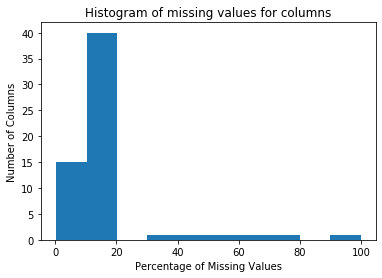

In [11]:
plt.hist(null_values_percentage)
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.title('Histogram of missing values for columns')
plt.show()

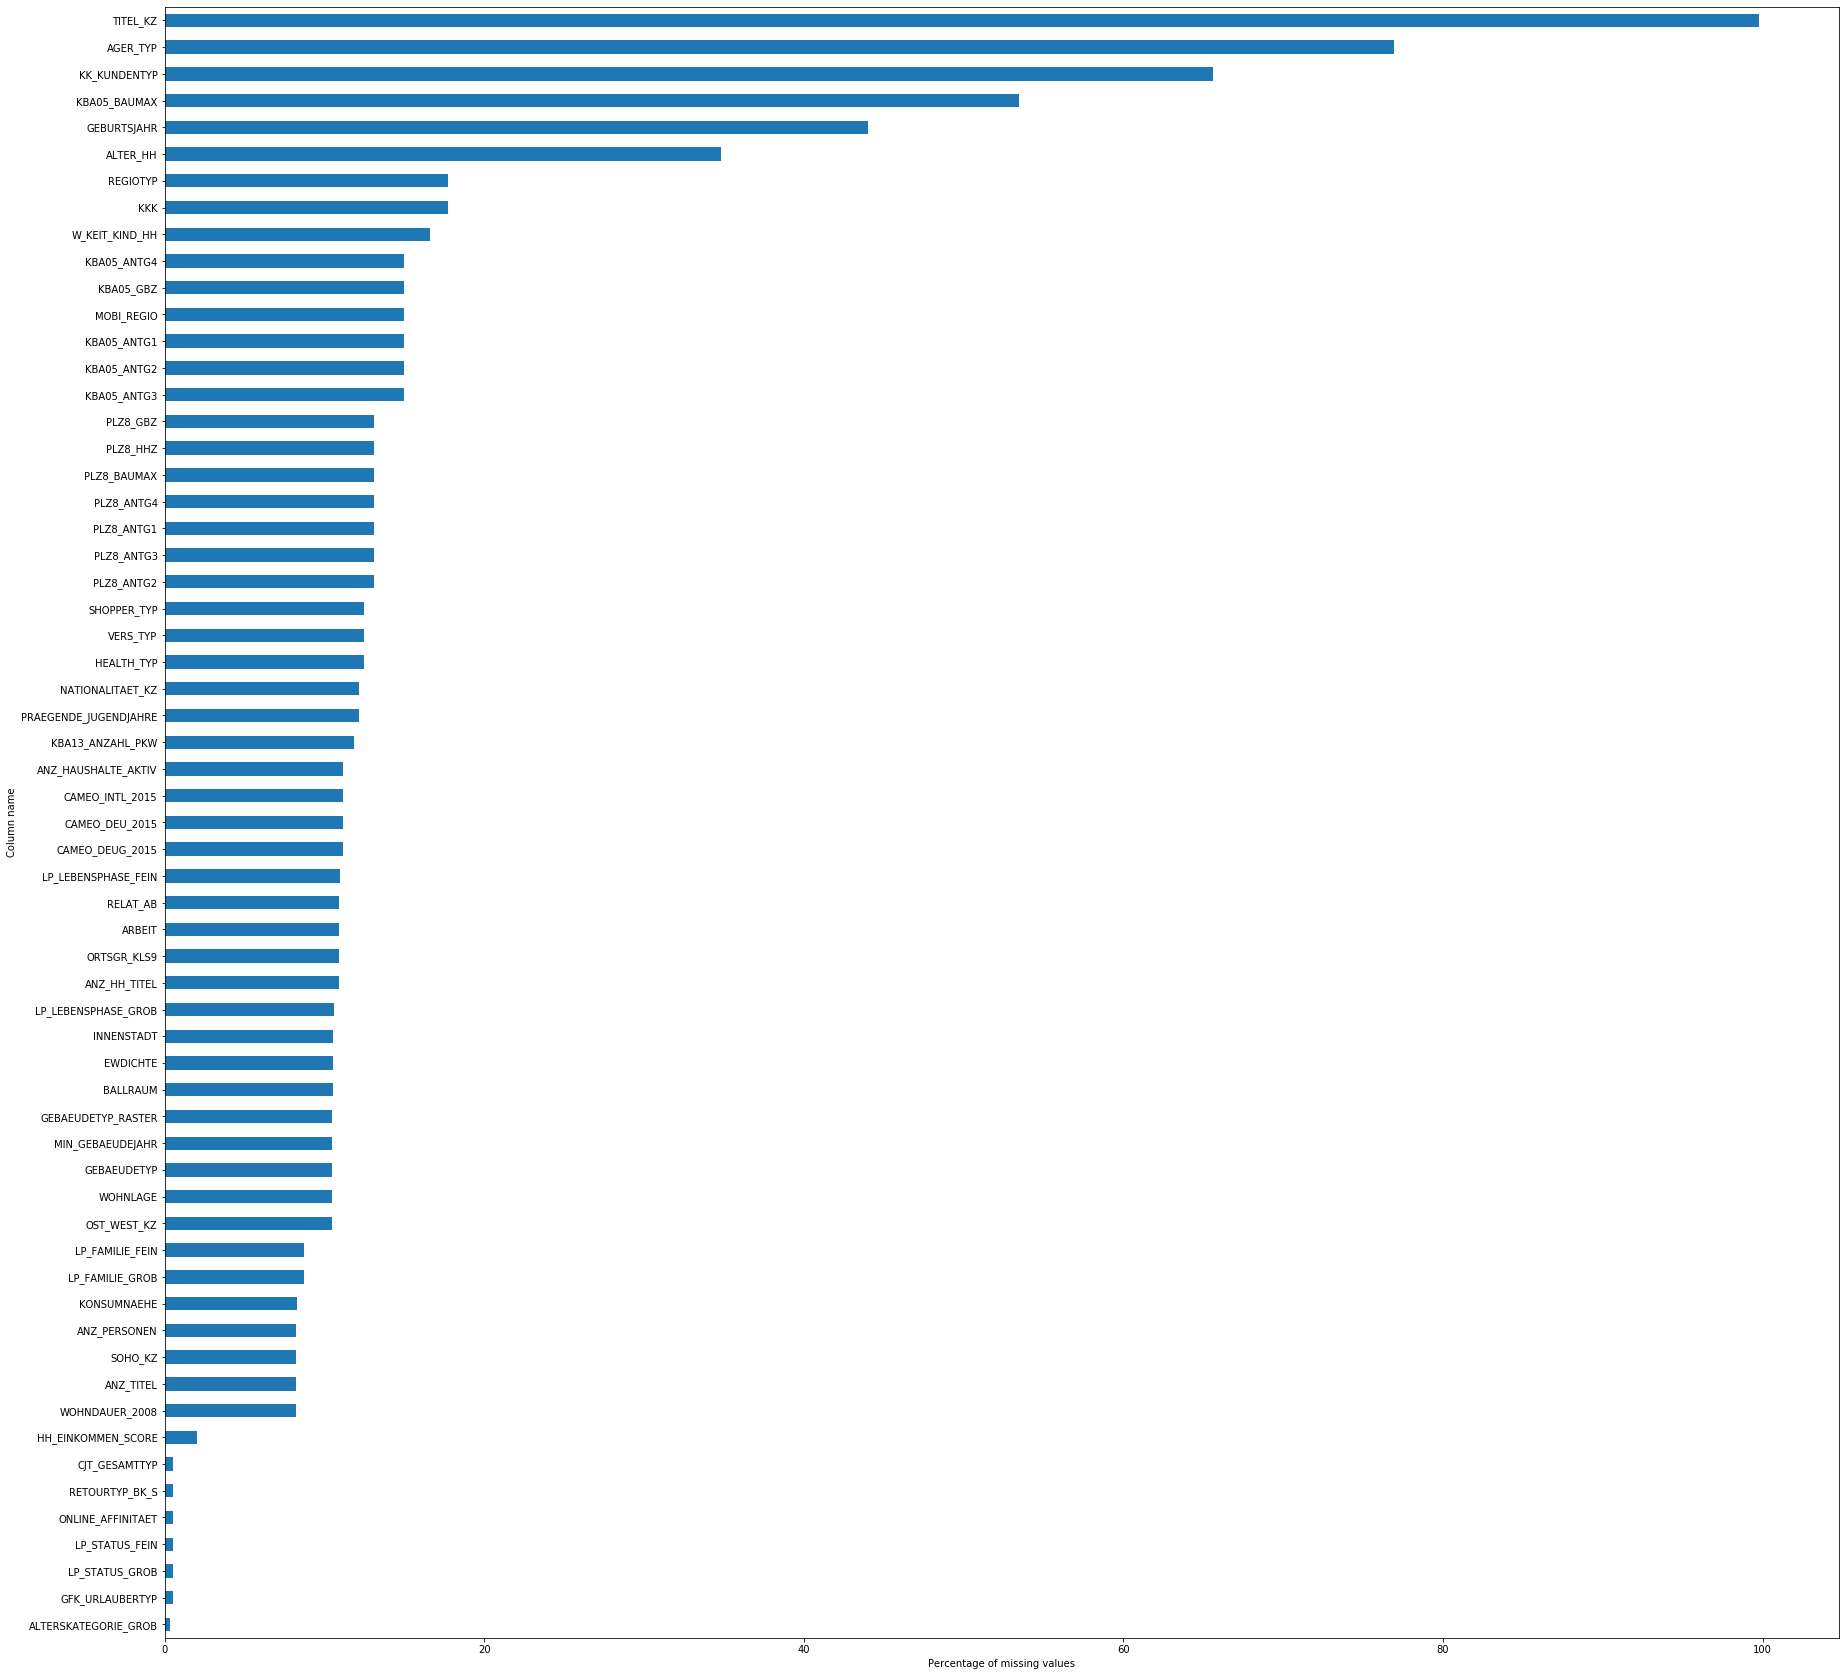

In [12]:
# Investigate patterns in the amount of missing data in each column.
null_values_percentage.plot.barh(figsize=(30,30))
plt.xlabel('Percentage of missing values')
plt.ylabel('Column name')
plt.show()

In [13]:

print('The columns with a percentage of missing values higher than 20%:\n{}'.format(null_values_percentage[null_values_percentage>20]))


The columns with a percentage of missing values higher than 20%:
ALTER_HH        34.813699
GEBURTSJAHR     44.020282
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
AGER_TYP        76.955435
TITEL_KZ        99.757636
dtype: float64


In [14]:
azdias.shape

(891221, 85)

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

drop_columns=null_values_percentage[null_values_percentage>20].index

#drop_columns
azdias.drop(columns=drop_columns,axis="columns",inplace=True)

azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

After investigating the missing values in each column through histogram and bar chart, i found that only six columns have more than 20% of its values as missing or unknown (Null). Those six columns (ALTER_HH, GEBURTSJAHR, KBA05_BAUMAX, KK_KUNDENTYP, AGER_TYP, TITEL_KZ) were dropped form the azdias dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?
missing_values_rows =azdias.isnull().sum(axis=1)
missing_values_rows

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

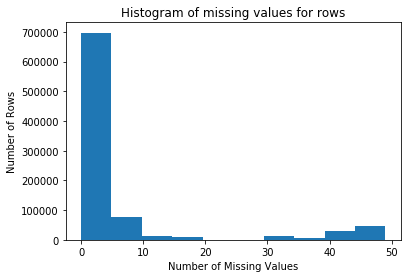

In [17]:
#Histogram of missing values for rows
missing_values_rows =azdias.isnull().sum(axis=1)
plt.hist(missing_values_rows)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.title('Histogram of missing values for rows')
plt.show()


In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_less_30=azdias[missing_values_rows<30]
azdias_above_30=azdias[missing_values_rows>=30]


In [19]:
azdias_less_30.shape


(798061, 79)

In [20]:
azdias_above_30.shape

(93160, 79)

In [21]:
azdias_less_30.shape[0]/azdias.shape[0]

0.895469249490306

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns = null_values_percentage[null_values_percentage<20].index
#Random_columns = columns.sample(5)

Random_columns = columns[:5]
print('The following random columns will be used for comparison:\n{}'.format(Random_columns))

The following random columns will be used for comparison:
Index(['ALTERSKATEGORIE_GROB', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB',
       'LP_STATUS_FEIN', 'ONLINE_AFFINITAET'],
      dtype='object')


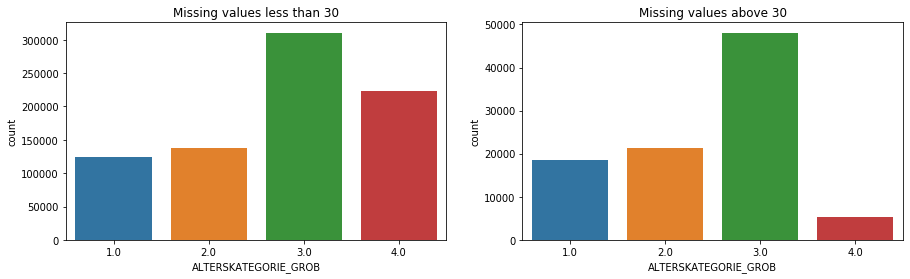

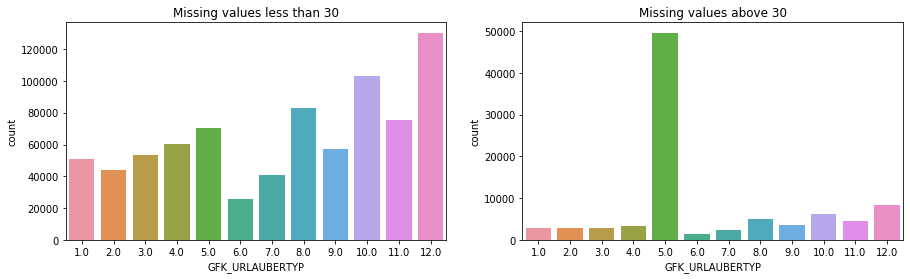

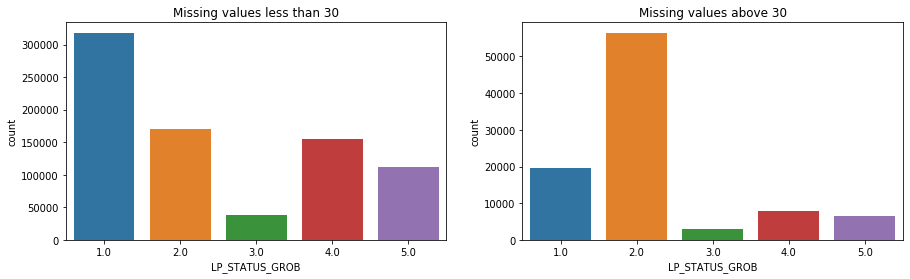

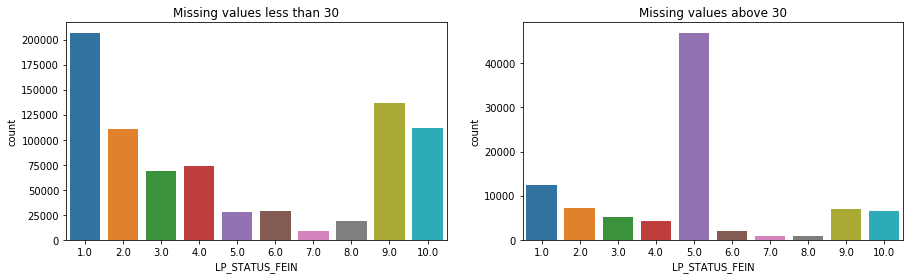

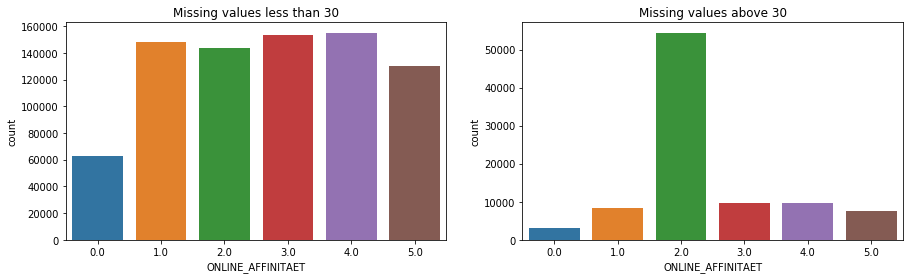

In [23]:
#Random_columns = Random_columns.index
for i in Random_columns:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('Missing values less than 30')
    sns.countplot(azdias.loc[azdias_less_30.index,i],ax=ax1)

    ax2.set_title('Missing values above 30')
    sns.countplot(azdias.loc[azdias_above_30.index,i],ax=ax2)
    
    plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

based on the 5 selected columns in the above diagrms, yes there are differences in the distributions of values between the 2 datasets.

In [24]:
azdias_less_30 = azdias_less_30.fillna(azdias_less_30.mode().iloc[0])
azdias_less_30.isnull().sum(axis=1)

1         0
2         0
3         0
4         0
5         0
         ..
891216    0
891217    0
891218    0
891219    0
891220    0
Length: 798061, dtype: int64

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?

feat_info=feat_info[feat_info.attribute.isin(azdias_less_30.columns)]
print('The following shows the feature type and its counts in the dataset:') 
feat_info.type.value_counts()


The following shows the feature type and its counts in the dataset:


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
cat_variables=feat_info[feat_info.type=="categorical"]

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_cat=[]
multi_level_cat=[]

for i in cat_variables.attribute:
    if azdias_less_30[i].nunique()==2:
        binary_cat.append(i)
    else:
        multi_level_cat.append(i)

#if condition
#drop the multi
#letters to int

In [28]:
print('There are {} Binary features:\n{}'.format(len(binary_cat), binary_cat))
print('\nThere are {} Multi-level features:\n{}'.format(len(multi_level_cat), multi_level_cat))

There are 5 Binary features:
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

There are 13 Multi-level features:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [29]:
for i in binary_cat:
    print('Unique values for {} are: {}'.format(i, azdias_less_30[i].unique()))

Unique values for ANREDE_KZ are: [2 1]
Unique values for GREEN_AVANTGARDE are: [0 1]
Unique values for SOHO_KZ are: [1. 0.]
Unique values for VERS_TYP are: [2. 1.]
Unique values for OST_WEST_KZ are: ['W' 'O']


In [34]:
for i in multi_level_cat:
    azdias_less_30=azdias_less_30.drop(i, axis=1)

In [35]:
azdias_less_30.shape

(798061, 66)

In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_less_30["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)

for i in binary_cat:
    print('Unique values for {} are: {}'.format(i, azdias_less_30[i].unique()))

Unique values for ANREDE_KZ are: [2 1]
Unique values for GREEN_AVANTGARDE are: [0 1]
Unique values for SOHO_KZ are: [1. 0.]
Unique values for VERS_TYP are: [2. 1.]
Unique values for OST_WEST_KZ are: [0 1]


#### Discussion 1.2.1: Re-Encode Categorical Features

1. I kept all the binary features: 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'
2. I re-encoded the values of 'OST_WEST_KZ' from letters [W,O] to [0, 1]
3. I dropped all the multi-level features

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_less_30.PRAEGENDE_JUGENDJAHRE.value_counts()
#azdias_less_30.PRAEGENDE_JUGENDJAHRE.head()


14.0    211738
8.0     141630
10.0     85808
5.0      84691
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [43]:
decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

azdias_less_30['DECADE']=azdias_less_30.PRAEGENDE_JUGENDJAHRE
azdias_less_30['MOVEMENT']=azdias_less_30.PRAEGENDE_JUGENDJAHRE

azdias_less_30['DECADE'].replace(decade_dic, inplace=True)
azdias_less_30['MOVEMENT'].replace(movement_dic, inplace=True)
azdias_less_30.drop("PRAEGENDE_JUGENDJAHRE",inplace=True)

In [45]:
azdias_less_30.DECADE.value_counts()

6.0    254285
4.0    175200
5.0    151770
3.0    114353
2.0     74296
1.0     28157
Name: DECADE, dtype: int64

In [46]:
azdias_less_30.MOVEMENT.value_counts()

1.0    622836
0.0    175225
Name: MOVEMENT, dtype: int64

In [50]:
azdias_less_30.shape

(798061, 67)

In [51]:
azdias_less_30.CAMEO_INTL_2015.value_counts()

51    139892
41     92336
24     91157
14     62884
43     56672
54     45391
25     39626
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19023
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

wealth_dic = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_dic = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_less_30["WEALTH"]=azdias_less_30.CAMEO_INTL_2015
azdias_less_30["LIFE_STAGE"]=azdias_less_30.CAMEO_INTL_2015

azdias_less_30["WEALTH"].replace(wealth_dic,inplace=True)
azdias_less_30["LIFE_STAGE"].replace(life_dic,inplace=True)

azdias_less_30.drop("CAMEO_INTL_2015",axis=1,inplace=True)

In [54]:
azdias_less_30.shape

(798061, 68)

In [55]:
azdias_less_30.WEALTH.value_counts()

5    229780
2    190687
4    189960
1    119442
3     68192
Name: WEALTH, dtype: int64

In [56]:
azdias_less_30.LIFE_STAGE.value_counts()

1    251251
4    232776
3    119692
5    117043
2     77299
Name: LIFE_STAGE, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

1. I droped the feature 'PRAEGENDE_JUGENDJAHRE' and replaced it with 2 new features:DECADE and MOVEMENT, while the third dimension west/east has been ignored.

2. I droped the feature 'CAMEO_INTL_2015' and replaced it with 2 new new features: WEALTH and LIFE_STAGE.

** The steps taken: 
1. created a dictionary for each mixed-feature.
2. created 2 variables for each mixed-feature and copied values from the initial mixed-value feature.
3. replaced the values in the variables with the values in the created dictionary.
4. droped the mixed-features 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [57]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

mixed_features=feat_info[feat_info.type=="mixed"]
for i in mixed_features["attribute"]:
    if i in azdias_less_30.columns:
        azdias_less_30.drop(i,axis=1,inplace=True)

In [58]:
azdias_less_30.shape

(798061, 64)

In [222]:
azdias_less_30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   798061 non-null  float64
 1   ANREDE_KZ              798061 non-null  int64  
 2   FINANZ_MINIMALIST      798061 non-null  int64  
 3   FINANZ_SPARER          798061 non-null  int64  
 4   FINANZ_VORSORGER       798061 non-null  int64  
 5   FINANZ_ANLEGER         798061 non-null  int64  
 6   FINANZ_UNAUFFAELLIGER  798061 non-null  int64  
 7   FINANZ_HAUSBAUER       798061 non-null  int64  
 8   GREEN_AVANTGARDE       798061 non-null  int64  
 9   HEALTH_TYP             798061 non-null  float64
 10  RETOURTYP_BK_S         798061 non-null  float64
 11  SEMIO_SOZ              798061 non-null  int64  
 12  SEMIO_FAM              798061 non-null  int64  
 13  SEMIO_REL              798061 non-null  int64  
 14  SEMIO_MAT              798061 non-nu

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [227]:
def missing_splited(missing_or_unknown):
    new_list=list()
    for values in missing_or_unknown:
        new_list.append(values[1:-1].split(","))
    return new_list

missing_values=missing_splited(feat_info["missing_or_unknown"])

def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    missing_values=missing_splited(feat_info["missing_or_unknown"])
    
    # Identify missing or unknown data values and convert them to NaNs.
    for attribute,missing_values_list in zip(feat_info["attribute"],missing_values):
            if missing_values_list[0] != "":  
                for missing_value in missing_values_list:
                #check if the missing value is number (negative or positive numbers)
                   if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                        missing_value = int(missing_value)

                df.loc[df[attribute] == missing_value, attribute] = np.nan 
              
                
                
    """
    for i in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[i]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_clean = df.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
    
    for col in df.columns:
        df_clean = df_clean.replace({col: ['XX', 'X']}, np.nan)
        """

    # remove selected columns and rows, ...
    # drop columns with more than 20% missing values
    columns_20 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean = df.drop(columns_20, axis='columns')
    
    missing_values_rows =df.isnull().sum(axis=1)
    df_less_30 = df_clean[missing_values_rows<30]
    df_above_30 = df_clean[missing_values_rows>=30]
    df_less_30 = df_clean.fillna(azdias_less_30.mode().iloc[0])
    
    # select, re-encode, and engineer column values.
    df_less_30["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True) 
        
    
    feat_info=feat_info[feat_info.attribute.isin(df_less_30.columns)]
    cat_variables=feat_info[feat_info.type=='categorical']
    binary_cat=[]
    multi_level_cat=[]
    
    for i in cat_variables.attribute:
        if df_less_30[i].nunique()==2:
            binary_cat.append(i)
        else:
            multi_level_cat.append(i)

    
    
    for i in multi_level_cat:
        df_less_30=df_less_30.drop(i, axis=1)
    
   
    
    decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

    df_less_30['DECADE']=df_less_30.PRAEGENDE_JUGENDJAHRE
    df_less_30['MOVEMENT']=df_less_30.PRAEGENDE_JUGENDJAHRE

    df_less_30['DECADE'].replace(decade_dic, inplace=True)
    df_less_30['MOVEMENT'].replace(movement_dic, inplace=True)
    #df_less_30.drop("PRAEGENDE_JUGENDJAHRE",inplace=True)

    wealth_dic = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

    life_dic = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}


    df_less_30["WEALTH"]=df_less_30.CAMEO_INTL_2015
    df_less_30["LIFE_STAGE"]=df_less_30.CAMEO_INTL_2015

    df_less_30["WEALTH"].replace(wealth_dic,inplace=True)
    df_less_30["LIFE_STAGE"].replace(life_dic,inplace=True)

    #df_less_30.drop("CAMEO_INTL_2015",axis=1,inplace=True)

    mixed_features=feat_info[feat_info.type=="mixed"]
    for i in mixed_features["attribute"]:
        if i in df_less_30.columns:
            df_less_30.drop(i,axis=1,inplace=True)
    
    # Return the cleaned dataframe.
    return df_less_30
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [68]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_less_30.isnull().sum().sum()

0

In [69]:
print("The number of columns in the azdias dataset: {}".format(len(azdias_less_30.columns)))
for i in azdias_less_30.columns:
    print(i)

The number of columns in the azdias dataset: 64
ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
VERS_TYP
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
DECADE
MOVEMENT
WEALTH
LIFE_STAGE


In [72]:
# Apply feature scaling to the general population demographics data.
scaler =StandardScaler()
features_scaled=scaler.fit_transform(azdias_less_30)
features_scaled=pd.DataFrame(features_scaled,columns=azdias_less_30.columns.tolist())
features_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,0.442528,1.455847,0.574305,-0.171400,-0.127041,0.684882,1.098070,0.530409,1.175657,-1.248894
1,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,-0.934798,0.419740,0.574305,-0.171400,-0.127041,-0.789027,1.098070,-1.885336,-0.869680,0.767095
2,1.184106,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.934798,-0.616366,0.574305,-1.173149,-0.997549,-0.052072,-0.267778,0.530409,-1.551459,-0.576897
3,0.200522,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,0.442528,-0.616366,-0.337195,0.830348,0.308213,1.421837,-0.267778,0.530409,0.493878,0.095099
4,-1.766646,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,0.442528,1.455847,1.485805,-1.173149,-0.997549,-0.052072,-1.633627,0.530409,1.175657,0.767095


### Discussion 2.1: Apply Feature Scaling

- Missing values were replaced with the mode in an earlier step. therefore there is 0 Null values in the dataset.
- All the features were scaled by using the StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [73]:
# Apply PCA to the data.
pca = PCA()
pca.fit(features_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

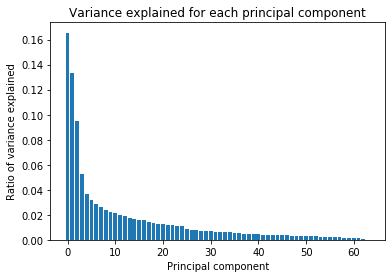

In [76]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained for each principal component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

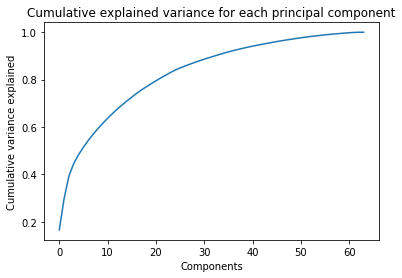

In [78]:
# Investigate the Cumulative values

plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative explained variance for each principal component")
plt.xlabel("Components")
plt.ylabel("Cumulative variance explained")
plt.show()

In [79]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_30 = PCA(n_components=30, random_state=10)
azdias_pca = pca_30.fit_transform(features_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

- I used 30 components as it expains above 80% of the variance

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [84]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(features_scaled.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights


In [85]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
first = pca_weights(pca_30,0)
print(first)

PLZ8_ANTG3            0.225345
PLZ8_ANTG4            0.216873
WEALTH                0.204628
HH_EINKOMMEN_SCORE    0.202187
ORTSGR_KLS9           0.196765
                        ...   
KBA05_ANTG1          -0.214438
KBA05_GBZ            -0.216061
FINANZ_MINIMALIST    -0.223092
MOBI_REGIO           -0.224811
PLZ8_ANTG1           -0.225665
Name: 0, Length: 64, dtype: float64


In [86]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second = pca_weights(pca_30,1)
print(second)


ALTERSKATEGORIE_GROB     0.256265
SEMIO_ERL                0.229915
FINANZ_VORSORGER         0.229239
SEMIO_LUST               0.180110
RETOURTYP_BK_S           0.161878
                           ...   
FINANZ_UNAUFFAELLIGER   -0.225492
SEMIO_TRADV             -0.228273
FINANZ_SPARER           -0.231660
DECADE                  -0.238553
SEMIO_REL               -0.253635
Name: 1, Length: 64, dtype: float64


In [87]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

third = pca_weights(pca_30,2)
print(third)

SEMIO_VERT           0.344664
SEMIO_SOZ            0.261932
SEMIO_FAM            0.248836
SEMIO_KULT           0.233936
FINANZ_MINIMALIST    0.154493
                       ...   
SEMIO_RAT           -0.217717
SEMIO_KRIT          -0.275200
SEMIO_DOM           -0.313070
SEMIO_KAEM          -0.335050
ANREDE_KZ           -0.367353
Name: 2, Length: 64, dtype: float64


### Discussion 2.3: Interpret Principal Components

**From the first principal component:**<br>
**The features with highest positive correlations with the first component:**
1. PLZ8_ANTG3        (Number of 6-10 family houses in the PLZ8 region)           
2. PLZ8_ANTG4        (Number of 10+ family houses in the PLZ8 region)           
3. WEALTH
<br>**The features with highest negative correlations with the first component:**       
1. PLZ8_ANTG1        (Number of 1-2 family houses in the PLZ8 region)
2. MOBI_REGIO        (Movement patterns)
3. FINANZ_MINIMALIST (Financial typology, low financial interest)
<br><br>**From the second principal component:**
<br>**The features with highest positive correlations with the second component:**
1. ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)   
2. SEMIO_ERL         (Personality typology, event-oriented)          
3. FINANZ_VORSORGER  (Financial typology, be prepared)
<br>**The features with highest negative correlations with the second component:**
1. SEMIO_REL         (Personality typology, religious)
2. DECADE
3. FINANZ_SPARER     (Financial typology, money-saver)
<br><br>**From the third principal component:**
<br>**The features with highest positive correlations with the third component:**
1. SEMIO_VERT        (Personality typology, dreamful)   
2. SEMIO_SOZ         (Personality typology, socially-minded)
3. SEMIO_FAM         (Personality typology, family-minded)
<br>**The features with highest negative correlations with the third component:**
1. ANREDE_KZ         (Gender)
2. SEMIO_KAEM        (Personality typology, combative attitude)
3. SEMIO_DOM         (Personality typology, dominant-minded)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [88]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
scores = []
clusters_num = list(range(1,20))
for i in clusters_num:
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(azdias_pca)
    # to compute the average
    score = np.abs(model.score(azdias_pca))
    scores.append(score) 

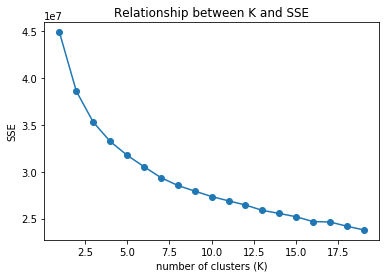

In [91]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(clusters_num,scores,marker='o',linestyle='-')
plt.xlabel('number of clusters (K)')
plt.ylabel('SSE')
plt.title('Relationship between K and SSE')
plt.show()

In [92]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 12)
model_12 = kmeans.fit(azdias_pca)
prediction = model_12.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

From the plot above, i choose k=12, since after that the score decreases when the number of clusters increases 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [228]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [229]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [230]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean= clean_data(customers,feat_info)

In [231]:
customers_clean.shape

(191652, 64)

In [232]:
customers_clean.isnull().sum().sum()

198082

In [233]:
# Replace NaN

customers_clean = customers_clean.fillna(customers_clean.mode().iloc[0])

In [234]:
customers_clean.isnull().sum().sum()

0

In [235]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   191652 non-null  float64
 1   ANREDE_KZ              191652 non-null  float64
 2   FINANZ_MINIMALIST      191652 non-null  float64
 3   FINANZ_SPARER          191652 non-null  float64
 4   FINANZ_VORSORGER       191652 non-null  float64
 5   FINANZ_ANLEGER         191652 non-null  float64
 6   FINANZ_UNAUFFAELLIGER  191652 non-null  float64
 7   FINANZ_HAUSBAUER       191652 non-null  float64
 8   GREEN_AVANTGARDE       191652 non-null  int64  
 9   HEALTH_TYP             191652 non-null  float64
 10  RETOURTYP_BK_S         191652 non-null  float64
 11  SEMIO_SOZ              191652 non-null  float64
 12  SEMIO_FAM              191652 non-null  float64
 13  SEMIO_REL              191652 non-null  float64
 14  SEMIO_MAT              191652 non-nu

In [236]:
#customers_clean.LIFE_STAGE = customers_clean.LIFE_STAGE.astype(float)
customers_clean.LIFE_STAGE.value_counts()

4.0    101001
5.0     29885
3.0     24661
1.0     22164
2.0     13941
Name: LIFE_STAGE, dtype: int64

In [237]:
customers_clean.WEALTH.value_counts()

2.0    91008
1.0    40262
4.0    29074
5.0    17645
3.0    13663
Name: WEALTH, dtype: int64

In [238]:
customers_clean.DECADE.value_counts()

2.0    91064
3.0    34073
4.0    26043
1.0    21721
5.0    12580
6.0     6171
Name: DECADE, dtype: int64

In [239]:
customers_clean.MOVEMENT.value_counts()

1.0    121283
0.0     70369
Name: MOVEMENT, dtype: int64

In [240]:
# Apply scaler
customers_clean_scaled = scaler.transform(customers_clean)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean))

In [241]:
# PCA 
customers_pca = pca_30.transform(customers_clean_scaled)

In [242]:
# Predict using Kmeans model_12
customers_pred = model_12.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5, 1.0, 'Customer Clusters')

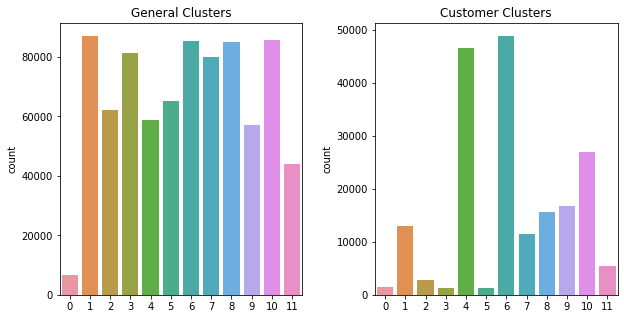

In [243]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(prediction, ax=axs[0])
axs[0].set_title('General Clusters')
sns.countplot(customers_pred, ax=axs[1])
axs[1].set_title('Customer Clusters')


In [244]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_6 = scaler.inverse_transform(pca_30.inverse_transform(model_12.cluster_centers_[6]))

In [245]:
overrepresented = pd.Series(data = centroid_6, index = customers_clean.columns)

In [259]:
print(overrepresented.sort_values().to_string())

SOHO_KZ                     0.000051
ANZ_TITEL                   0.002575
ANZ_HH_TITEL                0.006550
KBA05_ANTG4                 0.040201
OST_WEST_KZ                 0.142786
GREEN_AVANTGARDE            0.180226
KBA05_ANTG3                 0.240501
PLZ8_ANTG4                  0.253368
MOVEMENT                    0.819774
PLZ8_ANTG3                  1.014731
KBA05_ANTG2                 1.229796
VERS_TYP                    1.488176
ALTERSKATEGORIE_GROB        1.787574
ANREDE_KZ                   1.965870
ANZ_PERSONEN                1.966895
KBA05_ANTG1                 2.025348
FINANZ_VORSORGER            2.284820
FINANZ_MINIMALIST           2.316854
HEALTH_TYP                  2.339456
PLZ8_ANTG2                  2.417296
RELAT_AB                    2.500937
WEALTH                      2.521415
RETOURTYP_BK_S              2.540963
SEMIO_VERT                  2.553304
KKK                         2.663961
SEMIO_SOZ                   2.679798
ARBEIT                      2.743905
P

In [247]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_3 = scaler.inverse_transform(pca_30.inverse_transform(model_12.cluster_centers_[3]))
underrepresented = pd.Series(data = centroid_3, index = customers_clean.columns)

In [257]:
print(underrepresented.sort_values().to_string())

SOHO_KZ                     0.000002
ANZ_TITEL                   0.002333
GREEN_AVANTGARDE            0.039967
ANZ_HH_TITEL                0.040130
OST_WEST_KZ                 0.252737
KBA05_ANTG1                 0.407057
KBA05_ANTG4                 0.559709
MOVEMENT                    0.960033
FINANZ_MINIMALIST           1.179989
KBA05_ANTG3                 1.192120
PLZ8_ANTG4                  1.237169
KBA05_ANTG2                 1.312947
ANZ_PERSONEN                1.453370
PLZ8_ANTG1                  1.488396
VERS_TYP                    1.540002
ALTERSKATEGORIE_GROB        1.674290
MOBI_REGIO                  1.783588
ANREDE_KZ                   2.001280
LIFE_STAGE                  2.045662
KONSUMNAEHE                 2.109779
FINANZ_VORSORGER            2.201614
KBA05_GBZ                   2.204315
SEMIO_VERT                  2.223427
HEALTH_TYP                  2.316992
PLZ8_ANTG3                  2.407168
RETOURTYP_BK_S              2.668544
PLZ8_GBZ                    2.748147
K

In [263]:
entroids=pd.DataFrame({"Feature":customers_clean.columns,"Centroid 6":centroid_6,"Centroid 3":centroid_3})
print(entroids.to_string())

                  Feature   Centroid 6   Centroid 3
0    ALTERSKATEGORIE_GROB     1.787574     1.674290
1               ANREDE_KZ     1.965870     2.001280
2       FINANZ_MINIMALIST     2.316854     1.179989
3           FINANZ_SPARER     3.991814     4.293693
4        FINANZ_VORSORGER     2.284820     2.201614
5          FINANZ_ANLEGER     4.425112     4.155597
6   FINANZ_UNAUFFAELLIGER     3.915789     3.732428
7        FINANZ_HAUSBAUER     2.832219     4.166077
8        GREEN_AVANTGARDE     0.180226     0.039967
9              HEALTH_TYP     2.339456     2.316992
10         RETOURTYP_BK_S     2.540963     2.668544
11              SEMIO_SOZ     2.679798     3.189998
12              SEMIO_FAM     3.767906     3.947948
13              SEMIO_REL     5.233674     5.392917
14              SEMIO_MAT     5.019232     4.963532
15             SEMIO_VERT     2.553304     2.223427
16             SEMIO_LUST     3.222350     3.119856
17              SEMIO_ERL     4.380590     4.294618
18          

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f5dd4d0>]],
      dtype=object)

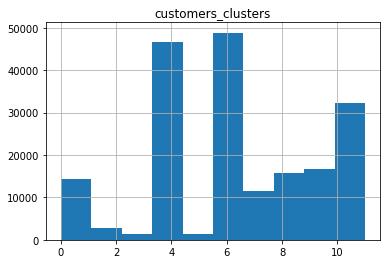

In [278]:
cust_clus = pd.DataFrame (customers_pred, columns = ['customers_clusters'])

cust_clus.hist ()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f439dd0>]],
      dtype=object)

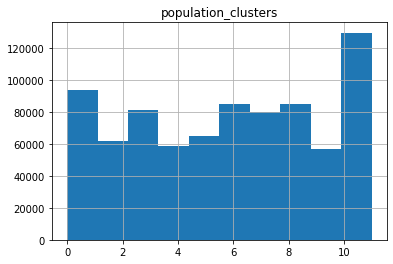

In [279]:
population_clus = pd.DataFrame (prediction, columns = ['population_clusters'])
population_clus.hist ()


In [280]:
population_prop = pd.DataFrame (population_clus.population_clusters.value_counts ())/ (features_scaled.shape [0]) * 100

population_prop.sort_index (inplace = True)
display (population_prop)

print (population_prop.sum ())

,population_clusters
0,0.841289
1,10.907813
2,7.771085
3,10.202604
4,7.370364
5,8.162158
6,10.683770
7,10.026427
8,10.643046
9,7.154340


population_clusters    100.0
dtype: float64


In [282]:
customers_prop = pd.DataFrame (cust_clus.customers_clusters.value_counts ())/ (customers_clean.shape [0]) * 100

customers_prop.sort_index (inplace = True)
display (customers_prop)

print (customers_prop.sum ())

,customers_clusters
0,0.745622
1,6.788867
2,1.497506
3,0.696053
4,24.318557
5,0.697619
6,25.488907
7,5.990545
8,8.191931
9,8.739799


customers_clusters    100.0
dtype: float64


In [285]:
azdias_clust = pd.DataFrame (population_clus, columns = ['population_clusters'])
azdias_clust.index = features_scaled.index 
display (azdias_clust.tail (n=10))
print (azdias_clust.shape)

,population_clusters
798051,8
798052,11
798053,9
798054,3
798055,3
798056,6
798057,8
798058,6
798059,5
798060,8


(798061, 1)


In [286]:
customers_clust = pd.DataFrame (cust_clus, columns = ['customers_clusters'])
customers_clust.index = customers_clean.index 
display (customers_clust.tail (n=10))
print (customers_clust.shape)

,customers_clusters
191642,11
191643,4
191644,1
191645,4
191646,3
191647,4
191648,7
191649,4
191650,7
191651,10


(191652, 1)


In [299]:
features_scaledLIFE_STAGE

array([-1.24889365,  0.7670949 , -0.57689747,  0.09509872,  1.43909109])

In [312]:


label=pd.DataFrame(prediction)
label.columns=['cluster']

label.index=azdias_less_30.index
azdias_less_30_new =pd.concat([features_scaled,label],axis=1)

cluster6=features_scaled.loc[azdias_clust['population_clusters']==6,:]
cluster6=cluster6.iloc[:,1:64]
for i in cluster6.columns:
    print(cluster6[i].value_counts()) 

 0.957914    83225
-1.043935     2038
Name: ANREDE_KZ, dtype: int64
-1.494594    32602
-0.768681    18837
 0.683144    15901
-0.042768    15450
 1.409057     2473
Name: FINANZ_MINIMALIST, dtype: int64
 0.864563    33084
 1.537924    28931
 0.191203    15127
-0.482158     6757
-1.155518     1364
Name: FINANZ_SPARER, dtype: int64
-1.040692    26399
-0.314404    24964
-1.766980    24462
 0.411884     8113
 1.138172     1325
Name: FINANZ_VORSORGER, dtype: int64
 1.465965    47236
 0.786978    25611
 0.107990     8939
-0.570998     2842
-1.249985      635
Name: FINANZ_ANLEGER, dtype: int64
 1.673172    34598
 0.958645    26056
 0.244119    16199
-0.470407     5581
-1.184933     2829
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
-0.791205    20548
 0.629141    19204
-1.501377    17210
-0.081032    15861
 1.339314    12440
Name: FINANZ_HAUSBAUER, dtype: int64
-0.530409    69686
 1.885336    15577
Name: GREEN_AVANTGARDE, dtype: int64
 1.010164    45591
-0.311816    25445
-1.633796    14227
Name: H

In [313]:
cluster3=features_scaled.loc[azdias_clust['population_clusters']==3,:]
cluster3=cluster3.iloc[:,1:64]
for i in cluster3.columns:
    print(cluster6[i].value_counts()) 

 0.957914    83225
-1.043935     2038
Name: ANREDE_KZ, dtype: int64
-1.494594    32602
-0.768681    18837
 0.683144    15901
-0.042768    15450
 1.409057     2473
Name: FINANZ_MINIMALIST, dtype: int64
 0.864563    33084
 1.537924    28931
 0.191203    15127
-0.482158     6757
-1.155518     1364
Name: FINANZ_SPARER, dtype: int64
-1.040692    26399
-0.314404    24964
-1.766980    24462
 0.411884     8113
 1.138172     1325
Name: FINANZ_VORSORGER, dtype: int64
 1.465965    47236
 0.786978    25611
 0.107990     8939
-0.570998     2842
-1.249985      635
Name: FINANZ_ANLEGER, dtype: int64
 1.673172    34598
 0.958645    26056
 0.244119    16199
-0.470407     5581
-1.184933     2829
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
-0.791205    20548
 0.629141    19204
-1.501377    17210
-0.081032    15861
 1.339314    12440
Name: FINANZ_HAUSBAUER, dtype: int64
-0.530409    69686
 1.885336    15577
Name: GREEN_AVANTGARDE, dtype: int64
 1.010164    45591
-0.311816    25445
-1.633796    14227
Name: H

### Discussion 3.3: Compare Customer Data to Demographics Data

- Cluster 6 is overrepresnted in the customer data (25.45%) compared to the general population (10.68%)
- Cluster 3 is underrepresented in the customers data (0.69%) compared to the general population (10.20%) 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.